## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
torch.cuda.set_device(1)

## Getting and converting the data

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [5]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [6]:
fname = '09/frame_00667_rgb.jpg'

In [7]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

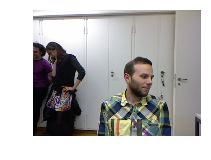

In [8]:
img = open_image(path/fname)
img.show()

In [9]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [10]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [11]:
get_ctr(fname)

tensor([263.9104, 428.5814])

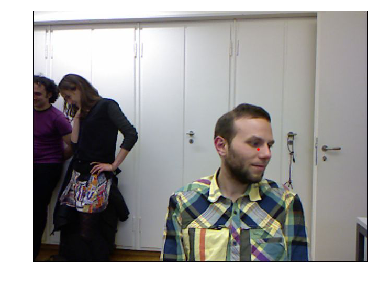

In [12]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [13]:
data = (ImageItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr, label_cls=PointsItemList)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

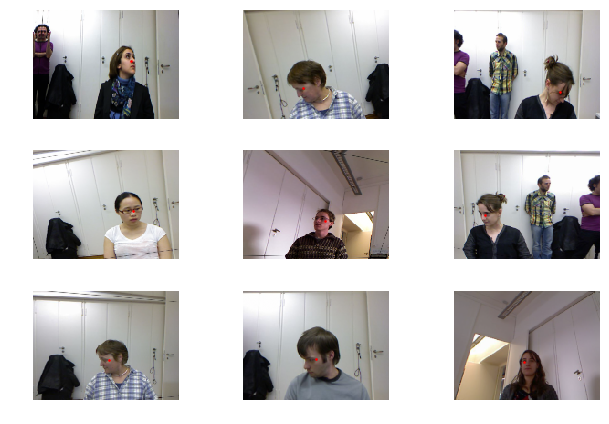

In [14]:
data.show_batch(3, figsize=(9,6))

## Train model

In [29]:
learn = create_cnn(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


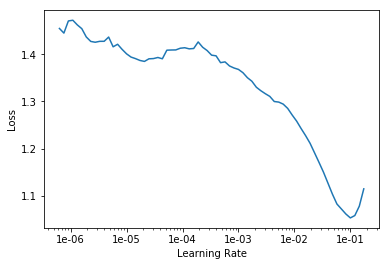

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
lr = 2e-2

In [18]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.054646,0.004741
2,0.019968,0.003354
3,0.009193,0.001717
4,0.005879,0.000745
5,0.004175,0.001222


In [24]:
learn.save('stage-1')

In [25]:
learn.load('stage-1');

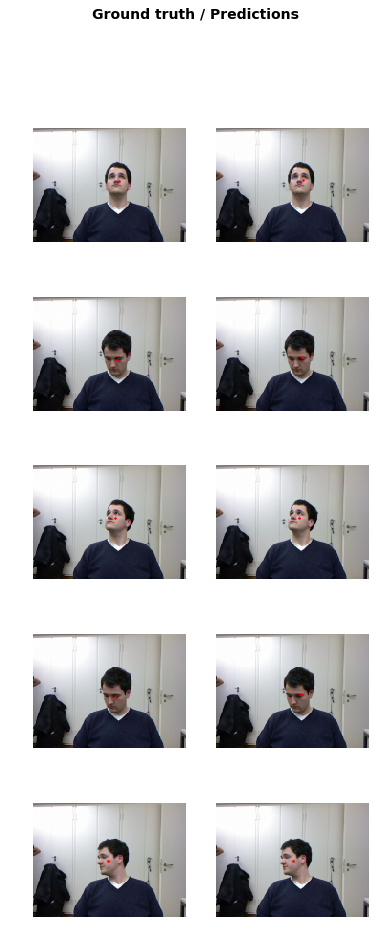

In [26]:
learn.show_results()

## Data augmentation

In [13]:
# tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)
tfms = get_transforms(max_rotate=20, max_zoom=1.05, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

# Haider: max_zoom=1.5 in the above line was giving error. 
# The default is 1.1 and seems even that at epoch gave error:



data = (ImageItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr, label_cls=PointsItemList)
        .transform(tfms, tfm_y=True, size=(120,160), padding_mode='zeros')
        .databunch().normalize(imagenet_stats)
       )

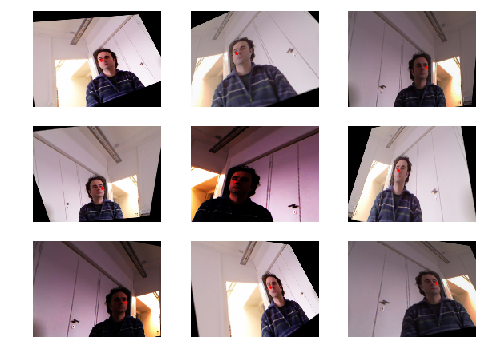

In [14]:
# Haider: shows the transform of only 1 image (the 1st image)
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

# fastai plot_multi for plotting multiple images
plot_multi(_plot, 3, 3, figsize=(8,6))

In [15]:
learn = create_cnn(data, models.resnet34)

In [16]:
lr = 2e-2

In [17]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.078759,0.020507
2,0.030596,0.027399
3,0.014775,0.011152
4,0.008294,0.006166
5,0.006258,0.004465


In [18]:
learn.save('stage-1')

In [19]:
learn.load('stage-1');

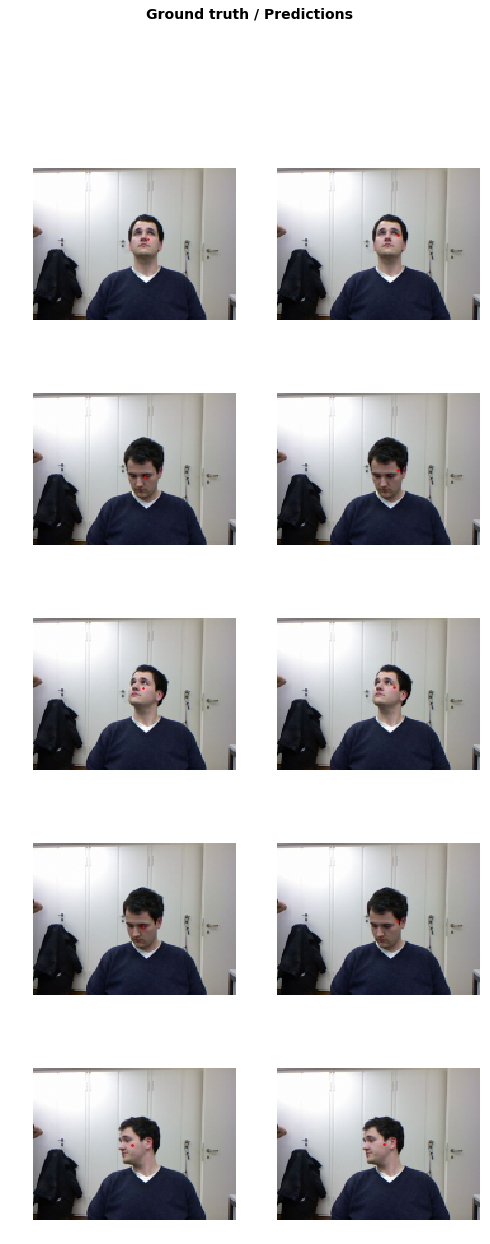

In [20]:
learn.show_results()

In [21]:
from my_python_tricks import *
notify_me()